# Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import scipy.io as sio
from keras.layers import Conv2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, auc
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.utils import np_utils
from keras.optimizers import SGD, Adam, RMSprop
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
dataPath = '../data/spectral_feat_tensor_full_with_full_labels_images.mat'
savePath = '../results/CNN_2D_our/'

experiment = 'MultiClass_NC'

filename = savePath+'CNN_2D_results_'+experiment+'.mat'
plot_title = 'Categorical Emotion Classification - NC'

nb_filters = [16, 32, 32, 64, 128]
kernel_size = 3
pool_size = 2
stride_size = 2
padding = 'same'
weight_decay = 0.000001
dense_layer_neuron_num = 128
epochs = 30
momentum =0.8

matContent = sio.loadmat(dataPath)
features = matContent['nc_feat_img']
print(features.shape)
labels = np.squeeze(matContent['nc_multi_labels'])
labels[labels < 0] = 0
features = np.swapaxes(features,1,3)
features = np.swapaxes(features,1,2)
labels[labels == 6] = 0
#labels = labels.astype(int)

#df = pd.read_csv(dataPath, header = None)
#features = df.iloc[1:,:-2].to_numpy()
#labels = df.iloc[1:,-1].to_numpy() # last but one column for PD vs NC

#dict_hvlv = {1:0, 2:1, 3:0, 4:0, 5:1, 6:0} #HVLV labels mapping dictionary
#labels = labels.map(dict_hvlv).to_numpy()
#labels[labels == 1] = 0
#labels[labels == 2] = 1
#labels[labels == 3] = 1
#labels[labels == 4] = 1
#labels[labels == 5] = 1
#labels[labels == 6] = 1
#labels[labels < 0]=0
#labels[labels == 6]=0

# randomise the sample sequence
rand_order = np.arange(features.shape[0])
np.random.shuffle(rand_order)
features = features[rand_order,]
labels = np.squeeze(labels[rand_order,])
class_num = np.size(np.unique(labels))
labels_categorical = np_utils.to_categorical(labels, class_num)
del matContent

print('Features shape:', features.shape)
print('Number of classes:', class_num)
print('Unique labels:', np.unique(labels))

(7412, 3, 32, 32)
Features shape: (7412, 32, 32, 3)
Number of classes: 6
Unique labels: [0 1 2 3 4 5]


In [3]:
def create_model(init_mode, activation, dropout_rate, optimizer, learn_rate):
#def create_model(activation):
  model = Sequential()
  model.add(Conv2D(filters=nb_filters[0], kernel_size=kernel_size, padding=padding,
                   activation=activation, input_shape=(features.shape[1], features.shape[2], features.shape[3]), trainable=True))
  model.add(AveragePooling2D(pool_size=pool_size, strides=stride_size, padding=padding))
  model.add(Conv2D(filters=nb_filters[1], kernel_size=kernel_size, padding=padding,
                   activation=activation, kernel_initializer=init_mode, trainable=True))
  model.add(AveragePooling2D(pool_size=pool_size, strides=stride_size, padding=padding))
  model.add(Conv2D(filters=nb_filters[2], kernel_size=kernel_size, padding=padding,
                   activation=activation, kernel_initializer=init_mode, trainable=True))
  model.add(AveragePooling2D(pool_size=pool_size, strides=stride_size, padding=padding))
  # ####added by me#####
  #model.add(Conv1D(filters=nb_filters[3], kernel_size=kernel_size, padding=padding, activation=activation,
  #              kernel_initializer='he_normal'))
  #model.add(AveragePooling1D(pool_size=pool_size, strides=stride_size, padding=padding))
  #model.add(Conv1D(filters=nb_filters[4], kernel_size=kernel_size, padding=padding, activation=activation,
  #              kernel_initializer='he_normal'))
  #model.add(AveragePooling1D(pool_size=pool_size, strides=stride_size, padding=padding))
  # ####added by me#####
  model.add(Flatten())
  model.add(BatchNormalization(epsilon=0.001))
  model.add(Dense(dense_layer_neuron_num, kernel_initializer=init_mode, activation=activation))
  model.add(Dropout(dropout_rate))
  model.add(Dense(class_num))
  model.add(Activation('softmax'))
  #model.summary()
  #model.load_weights('Gender_notClean_HIweights.hdf5')
  #earlyStopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
  if optimizer == 'SGD':
    opt = SGD(learning_rate=learn_rate / 10 ** epochs, momentum = momentum, decay = weight_decay, nesterov = True)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  elif optimizer == 'Adam':
    opt = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  elif optimizer == 'RMSprop':
    opt = RMSprop(learning_rate=learn_rate, epsilon=1e-07)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model


In [ ]:
cnn_model = KerasClassifier(build_fn=create_model, verbose=0)

#batch_size = [16,32]
#epochs = [5,10,15]
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'he_normal', 'he_uniform']
#activation = ['softmax', 'softsign', 'relu', 'tanh', 'sigmoid', 'linear']
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#neurons = [1, 5, 10, 15, 20, 25, 30]

learn_rate = [0.00001, 0.0001, 0.001]
optimizer = ['SGD', 'Adam','RMSprop']
#momentum = [0.8,0.9]
init_mode = ['he_normal','he_uniform']
activation = ['relu','tanh']
dropout_rate = [0.3,0.4,0.5]
foldNum = 10

p_grid = dict(init_mode=init_mode, dropout_rate=dropout_rate, activation=activation,
              optimizer=optimizer, learn_rate=learn_rate)
              #, momentum=momentum)
grid = GridSearchCV(estimator=cnn_model, param_grid=p_grid,
                    cv=foldNum, verbose=0)
# Standerdize
#feat_shape = features.shape
#features = np.reshape(features, (feat_shape[0], feat_shape[1]*feat_shape[2]))
#scaler = StandardScaler()
#scaler.fit(features)
#scaleFeatures = scaler.transform(features)
#scaleFeatures = np.reshape(scaleFeatures, (features.shape[0], 6, -1))

print('Performing Gridsearch')
grid_result = grid.fit(features,labels_categorical)
best_params = grid_result.best_params_
print('Best parameters:', best_params)
tf.keras.backend.clear_session()#to clear any previosuly obtiained models
estimator = create_model(init_mode=best_params.get('init_mode'), 
                         learn_rate=best_params.get('learn_rate'), 
                         optimizer=best_params.get('optimizer'), 
                         #momentum=best_params.get('momentum'), 
                         activation=best_params.get('activation'), 
                         dropout_rate=best_params.get('dropout_rate'))

In [4]:
mat_path = '../results/CNN_2D_our/CNN_2D_results_MultiClass_NC.mat'
params = sio.loadmat(mat_path)
best_params = params['best_params']
del mat_path
print(best_params)

[[(array(['tanh'], dtype='<U4'), array([[0.3]]), array(['he_uniform'], dtype='<U10'), array([[0.0001]]), array(['Adam'], dtype='<U4'))]]


In [5]:
tf.keras.backend.clear_session()
estimator = create_model(init_mode='he_uniform', learn_rate=0.0001, optimizer='Adam', activation='tanh', 
                         dropout_rate=0.3)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
average_pooling2d_1 (Average (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
average_pooling2d_2 (Average (None, 4, 4, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

/home/soujanya/anaconda3/envs/eegenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/soujanya/anaconda3/envs/eegenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


MultiClass_NC_CNN: Fold 1 : f1_macroscore: 0.6920
MultiClass_NC_CNN: Fold 1 : f1_weightedscore: 0.6926
MultiClass_NC_CNN: Fold 1 : acc: 0.6914
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
average_pooling2d_1 (Average (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
average_pooling2d_2 (Average (None, 4, 4, 32)

Epoch 11/30
188/188 - 1s - loss: 0.5445 - accuracy: 0.8019 - val_loss: 0.6922 - val_accuracy: 0.7560
Epoch 12/30
188/188 - 1s - loss: 0.5469 - accuracy: 0.8006 - val_loss: 0.7268 - val_accuracy: 0.7395
Epoch 13/30
188/188 - 1s - loss: 0.5562 - accuracy: 0.7976 - val_loss: 0.6993 - val_accuracy: 0.7515
Epoch 14/30
188/188 - 1s - loss: 0.5330 - accuracy: 0.8069 - val_loss: 0.7282 - val_accuracy: 0.7365
Epoch 15/30
188/188 - 1s - loss: 0.5508 - accuracy: 0.7971 - val_loss: 0.7008 - val_accuracy: 0.7590
Epoch 16/30
188/188 - 1s - loss: 0.5455 - accuracy: 0.7988 - val_loss: 0.7095 - val_accuracy: 0.7590
Epoch 17/30
188/188 - 1s - loss: 0.5251 - accuracy: 0.8068 - val_loss: 0.7272 - val_accuracy: 0.7425
Epoch 18/30
188/188 - 1s - loss: 0.5090 - accuracy: 0.8166 - val_loss: 0.7147 - val_accuracy: 0.7530
Epoch 19/30
188/188 - 1s - loss: 0.5068 - accuracy: 0.8168 - val_loss: 0.7230 - val_accuracy: 0.7485
Epoch 20/30
188/188 - 1s - loss: 0.4929 - accuracy: 0.8198 - val_loss: 0.7242 - val_accurac

Epoch 1/30
188/188 - 1s - loss: 0.4222 - accuracy: 0.8541 - val_loss: 0.6687 - val_accuracy: 0.7859
Epoch 2/30
188/188 - 1s - loss: 0.4023 - accuracy: 0.8521 - val_loss: 0.6836 - val_accuracy: 0.7769
Epoch 3/30
188/188 - 1s - loss: 0.3891 - accuracy: 0.8556 - val_loss: 0.6875 - val_accuracy: 0.7769
Epoch 4/30
188/188 - 1s - loss: 0.3851 - accuracy: 0.8652 - val_loss: 0.7048 - val_accuracy: 0.7769
Epoch 5/30
188/188 - 1s - loss: 0.3694 - accuracy: 0.8656 - val_loss: 0.6948 - val_accuracy: 0.7934
Epoch 6/30
188/188 - 1s - loss: 0.3688 - accuracy: 0.8666 - val_loss: 0.6961 - val_accuracy: 0.7829
Epoch 7/30
188/188 - 1s - loss: 0.3615 - accuracy: 0.8709 - val_loss: 0.7000 - val_accuracy: 0.7799
Epoch 8/30
188/188 - 1s - loss: 0.3616 - accuracy: 0.8687 - val_loss: 0.6999 - val_accuracy: 0.7859
Epoch 9/30
188/188 - 1s - loss: 0.3587 - accuracy: 0.8726 - val_loss: 0.6895 - val_accuracy: 0.7784
Epoch 10/30
188/188 - 2s - loss: 0.3649 - accuracy: 0.8669 - val_loss: 0.6883 - val_accuracy: 0.7889

Epoch 1/30
188/188 - 1s - loss: 0.2984 - accuracy: 0.8931 - val_loss: 0.7525 - val_accuracy: 0.7799
Epoch 2/30
188/188 - 1s - loss: 0.3012 - accuracy: 0.8922 - val_loss: 0.7685 - val_accuracy: 0.7829
Epoch 3/30
188/188 - 1s - loss: 0.2862 - accuracy: 0.8939 - val_loss: 0.7560 - val_accuracy: 0.7784
Epoch 4/30
188/188 - 1s - loss: 0.2650 - accuracy: 0.9057 - val_loss: 0.7114 - val_accuracy: 0.7994
Epoch 5/30
188/188 - 1s - loss: 0.2672 - accuracy: 0.9022 - val_loss: 0.7455 - val_accuracy: 0.7919
Epoch 6/30
188/188 - 1s - loss: 0.2741 - accuracy: 0.8991 - val_loss: 0.7009 - val_accuracy: 0.8024
Epoch 7/30
188/188 - 1s - loss: 0.2604 - accuracy: 0.9064 - val_loss: 0.7210 - val_accuracy: 0.7994
Epoch 8/30
188/188 - 1s - loss: 0.2655 - accuracy: 0.9037 - val_loss: 0.7211 - val_accuracy: 0.7979
Epoch 9/30
188/188 - 1s - loss: 0.2652 - accuracy: 0.9070 - val_loss: 0.7409 - val_accuracy: 0.7740
Epoch 10/30
188/188 - 1s - loss: 0.2552 - accuracy: 0.9039 - val_loss: 0.7039 - val_accuracy: 0.7964

Epoch 1/30
188/188 - 1s - loss: 0.2341 - accuracy: 0.9159 - val_loss: 0.7524 - val_accuracy: 0.8204
Epoch 2/30
188/188 - 1s - loss: 0.2191 - accuracy: 0.9210 - val_loss: 0.7956 - val_accuracy: 0.7949
Epoch 3/30
188/188 - 1s - loss: 0.2120 - accuracy: 0.9212 - val_loss: 0.7627 - val_accuracy: 0.8054
Epoch 4/30
188/188 - 1s - loss: 0.2190 - accuracy: 0.9234 - val_loss: 0.7733 - val_accuracy: 0.7964
Epoch 5/30
188/188 - 1s - loss: 0.2217 - accuracy: 0.9204 - val_loss: 0.7972 - val_accuracy: 0.8024
Epoch 6/30
188/188 - 1s - loss: 0.2090 - accuracy: 0.9230 - val_loss: 0.7431 - val_accuracy: 0.8144
Epoch 7/30
188/188 - 1s - loss: 0.2192 - accuracy: 0.9247 - val_loss: 0.7212 - val_accuracy: 0.8099
Epoch 8/30
188/188 - 1s - loss: 0.2004 - accuracy: 0.9287 - val_loss: 0.7821 - val_accuracy: 0.7979
Epoch 9/30
188/188 - 1s - loss: 0.2162 - accuracy: 0.9262 - val_loss: 0.7640 - val_accuracy: 0.8024
Epoch 10/30
188/188 - 1s - loss: 0.2039 - accuracy: 0.9292 - val_loss: 0.7781 - val_accuracy: 0.7934

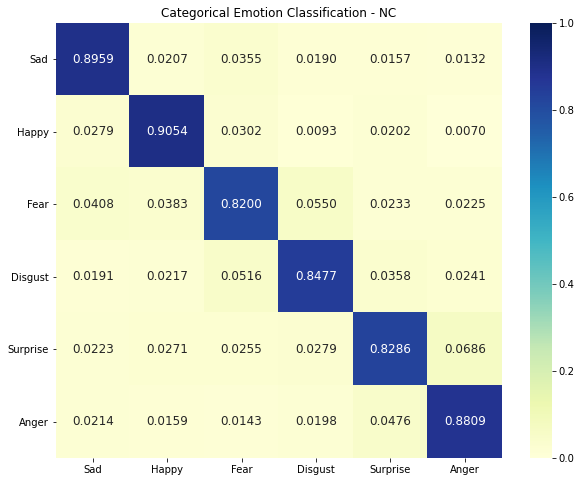

Mean and std of F1 MACRO is 0.8628 +- 0.0790
Mean and std of F1 WEIGHTED is 0.8632 +- 0.0789
Mean and std of accuracy is 0.8635 +- 0.0788


In [6]:
#conf_mat = np.zeros((2,2))
conf_mat = np.zeros((6,6))
f = 0
foldNum = 10
cm_list = []
val_loss = []
val_accuracy = []
train_loss = []
train_accuracy = []
f1_MacroNet = np.zeros([foldNum,]) 
f1_weightedNet = np.zeros([foldNum,])
precisionNet = np.zeros([foldNum,])
recallNet = np.zeros([foldNum,])
accNet = np.zeros([foldNum,])

#channels = features.shape[2] # number of channels 14
kfold = StratifiedKFold(n_splits=10, random_state=100, shuffle=True)

for train, test in kfold.split(features, labels):
    trainingFeatures = features[train,:,:, :]
    testFeatures = features[test,:,:, :]
    train_shape = trainingFeatures.shape
    test_shape = testFeatures.shape
    tf.keras.backend.clear_session()#to clear any previosuly obtiained models
    estimator.summary()
    dummy = estimator.fit(trainingFeatures, labels_categorical[train,:], batch_size=32, 
                          epochs=epochs, verbose=2, validation_split=0.1)
    predicted_labelsNet = estimator.predict_classes(testFeatures, verbose=0)
    predicted_probsNet = estimator.predict_proba(testFeatures,batch_size=1,verbose=0)
    #cm = confusion_matrix(labels[test,], predicted_labelsNet, labels=[0,1])
    cm = confusion_matrix(labels[test,], predicted_labelsNet, labels=[1,2,3,4,5,0])
    cm = cm/cm.sum(axis=1, keepdims=True)
    #conf_mat = conf_mat+cm
    cm_list.append(cm)

    precisionNet[f] = precision_score(labels[test,], predicted_labelsNet, average='macro')
    recallNet[f] = recall_score(labels[test,], predicted_labelsNet, average='macro')
    f1_MacroNet[f] = f1_score(labels[test,], predicted_labelsNet, average='macro')
    f1_weightedNet[f] = f1_score(labels[test,], predicted_labelsNet, average='weighted')
    accNet[f] = accuracy_score(labels[test,], predicted_labelsNet)
    print(experiment + '_CNN: Fold %d : f1_macroscore: %.4f' % (f + 1, f1_MacroNet[f]))
    print(experiment + '_CNN: Fold %d : f1_weightedscore: %.4f' % (f + 1, f1_weightedNet[f]))
    print(experiment + '_CNN: Fold %d : acc: %.4f' % (f + 1, accNet[f]))
    f += 1
    train_loss.append(dummy.history['loss'])
    val_loss.append(dummy.history['val_loss'])
    train_accuracy.append(dummy.history['accuracy'])
    val_accuracy.append(dummy.history['val_accuracy'])

conf_mat = np.mean(cm_list, axis=0)
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(conf_mat, cmap='YlGnBu', annot = True, fmt='.4f', vmin=0, vmax=1, annot_kws = {'fontsize':12})
#ax.set_yticklabels(['NC', 'PD'], rotation = 0) # for CSP and IIR
#ax.set_yticklabels(['NC', 'PD'], rotation = 0) # for spectral
ax.set_yticklabels(['Sad', 'Happy', 'Fear', 'Disgust', 'Surprise', 'Anger'], rotation = 0)
ax.set_xticklabels(['Sad', 'Happy', 'Fear', 'Disgust', 'Surprise', 'Anger'], rotation = 0)

ax.set_title(plot_title)
ax.get_figure().savefig(filename[:-4]+'_conf_mat'+'.png')
plt.show()

print('Mean and std of F1 MACRO is %.4f +- %.4f' % (np.mean(f1_MacroNet), np.std(f1_MacroNet)))
print('Mean and std of F1 WEIGHTED is %.4f +- %.4f' % (np.mean(f1_weightedNet), np.std(f1_weightedNet)))
print('Mean and std of accuracy is %.4f +- %.4f' % (np.mean(accNet), np.std(accNet)))

# Save results
sio.savemat(filename, {'precisionNet': precisionNet,'recallNet': recallNet, 'f1_MacroNet': f1_MacroNet,
                       'f1_weightedNet':f1_weightedNet,'accNet':accNet, 'conf_mat':conf_mat, 'conf_mat_list':cm_list,
                       'best_params':best_params, 'experiment':experiment,'nb_filters':nb_filters,
                       'kernel_size':kernel_size, 'pool_size':pool_size, 'stride_size':stride_size,'padding':padding,
                       'weight_decay':weight_decay, 'dense_layer_neuron_num':dense_layer_neuron_num,'epochs':epochs,
                      'train_loss':train_loss, 'train_accuracy':train_accuracy, 'val_loss':val_loss,
                       'val_accuracy':val_accuracy})